# Objetivos deste trabalho:
- Se familiarizar com o ambiente Notebook e com Python
- Implementar um perceptron simples, treiná-lo no conjunto de TREINO do CIFAR-10 e avaliá-lo no conjunto de TESTE (alvo: distinguir fotos de animais de meios de transporte)
- Utilizar a função sigmóide e verificar seu efeito no treinamento e na avaliação
- Modificar a metodologia para classificar cada classe individualmente (i.e. treinar 10 perceptrons, um para cada classe). Considerar: dado um exemplo, que passará por cada perceptron, como decidir qual é a classe dele?

In [1]:
%matplotlib inline

import torch
import torchvision
import numpy as np

np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# Carregar os datasets

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
print(len(dataset_train), len(dataset_test))

50000 10000


In [5]:
# Converter para tons de cinza

# Treino
grayscale_dataset_train = []
for img,label in dataset_train:
    category = classes[label]
    gray_npimg = np.array(img.convert('L'))
    grayscale_dataset_train.append((gray_npimg,category))
    
# Teste
grayscale_dataset_test = []
for img,label in dataset_test:
    category = classes[label]
    gray_npimg = np.array(img.convert('L'))
    grayscale_dataset_test.append((gray_npimg,category))    

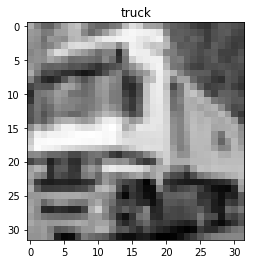

In [6]:
# Mostrar uma imagem

import matplotlib.pyplot as plt
import numpy as np

image_index = 1
label = grayscale_dataset_train[image_index][1]
npimg = grayscale_dataset_train[image_index][0]

plt.imshow(npimg, cmap='gray')
plt.title(label)
plt.show()

In [7]:
# Converter para vetores 1D

# Para pensar: por que a divisão por 255 no código abaixo?

linear_dataset_train = []
target_labels = ('plane', 'car', 'ship', 'truck')
for img,category in grayscale_dataset_train:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    if category in target_labels:
        label = 1
    else:
        label = 0
    linear_dataset_train.append((linear_img,label))
    
linear_dataset_test = []
target_labels = ('plane', 'car', 'ship', 'truck')
for img,category in grayscale_dataset_test:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    if category in target_labels:
        label = 1
    else:
        label = 0
    linear_dataset_test.append((linear_img,label))    

In [8]:
size = len(linear_dataset_train[0][0])
print(size)

1024


# Definindo o perceptron

In [9]:
# Função Sigmoid
def sigmoid(x):
    return 1/(1+np.exp(-x))

# Função Degrau
def step(x):
    if x > 0:
        return 1
    else:
        return 0  

# Função Perceptron
def perceptron(inputs, weights):
    
    # Soma de todas entradas multiplicadas pelos pesos
    o = np.sum(inputs * weights)
    
    # Função de ativação
    y = sigmoid(o)
    
    # Retorna o resultado do perceptron
    return y
  

# Treinando o perceptron

In [10]:
# Função que retorna os valores
# True Positive, False Positive, True Negative e False Negative
def evaluate(weights, dataset):
    
    # Inicialização
    tp, fp, fn, tn = 0, 0, 0, 0
    
    # Percorre todas as imagens do dataset
    for img,label in dataset:
        
        # Adiciona o bias no fim da imagem
        img = np.append(img, 1)
        
        # Saida do perceptron
        y = perceptron(img, weights)
        
        # Acima de 0.8 considera que é 1, abaixo é 0
        s = y
        if y > 0.5:
            s = 1
        else:
            s = 0
        
        # Se o label == 1
        if label == 1:
            
            # e a saida é 1, é verdadeiro positivo
            if s == 1:
                tp += 1
            
            # Se a saida é 0, é falso negativo
            else:
                fn += 1
        # Se o label == 0
        else:
          
            # e a saída é 1, é falso positivo
            if s == 1:
                fp += 1
            
            # Se a saída é 0, é verdadeiro negativo
            else:
                tn += 1
          
    # Acuracia
    acuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Sensitividade
    recall = tp / (tp + fn)
    
    # Especificidade
    specificity = tn / (tn + fp)
    
    # Retorna os 3
    return acuracy, recall, specificity


In [11]:
# Inicialização
weights = (np.random.rand(1,size) - 0.5)[0]
bias = (np.random.rand(1) - 0.5) 
weights = np.append(weights, bias) 

# Valor do Neta
neta = 0.0001

# Valor do momento
momentum = 0.9

# Lista de todas as acuracias por época
accuracies, recalls, specificities = [], [], []

# Delta_w anterior
w = 0

# Épocas
for epoch in range(50):
    
    # A cada época, dá shuffle no dataset
    np.random.shuffle(linear_dataset_train)
    
    # Para cada exemplo no dataset de treino 
    for img, label in linear_dataset_train:
      
        # Adiciona o valor do Bias no fim da imagem
        img = np.append(img, 1)

        # Saída do Perceptron
        y = perceptron(img, weights)

        # Atualização dos pesos
        loss = momentum * w + (label - y) * neta * img * (y * (1-y))
        weights += loss
        w = loss
    
    # Saida do evaluate contendo Acurácia, Sensitividade e Especificidade
    out = evaluate(weights, linear_dataset_train)
    
    # Adiciona os valores do evaluate
    accuracies.append(out[0])
    recalls.append(out[1]) 
    specificities.append(out[2])
    
    # Printa a Acurácia
    print('Epoch ' + str(epoch + 1) + ':', accuracies[-1])

Epoch 1: 0.69516
Epoch 2: 0.69422
Epoch 3: 0.7003
Epoch 4: 0.70248
Epoch 5: 0.70838
Epoch 6: 0.70804
Epoch 7: 0.71268
Epoch 8: 0.71556
Epoch 9: 0.71658
Epoch 10: 0.70954
Epoch 11: 0.71822
Epoch 12: 0.71812
Epoch 13: 0.71746
Epoch 14: 0.71784
Epoch 15: 0.71952
Epoch 16: 0.71996
Epoch 17: 0.71538
Epoch 18: 0.72286
Epoch 19: 0.72226
Epoch 20: 0.72582
Epoch 21: 0.7262
Epoch 22: 0.7225
Epoch 23: 0.70682
Epoch 24: 0.72366
Epoch 25: 0.72778
Epoch 26: 0.72776
Epoch 27: 0.7268
Epoch 28: 0.72738
Epoch 29: 0.72918
Epoch 30: 0.72944
Epoch 31: 0.7294
Epoch 32: 0.72984
Epoch 33: 0.72616
Epoch 34: 0.7298
Epoch 35: 0.72946
Epoch 36: 0.73
Epoch 37: 0.72812
Epoch 38: 0.72692
Epoch 39: 0.73084
Epoch 40: 0.73122
Epoch 41: 0.72958
Epoch 42: 0.72656
Epoch 43: 0.73068
Epoch 44: 0.73048
Epoch 45: 0.7268
Epoch 46: 0.73212
Epoch 47: 0.72948
Epoch 48: 0.72662
Epoch 49: 0.72942
Epoch 50: 0.72398


In [12]:
# Avalie o modelo treinado aqui
# Como a acurácia no conjunto de teste se compara com a acurácia obtida no conjunto de treino?

test_acuracie, test_recall, test_specificity  = evaluate(weights, linear_dataset_test) 
print('Acurácia do Teste:', test_acuracie)
print('Sensitividade do Teste:', test_recall)
print('Especificidade do Teste:', test_specificity)

Acurácia do Teste: 0.7161
Sensitividade do Teste: 0.61525
Especificidade do Teste: 0.7833333333333333


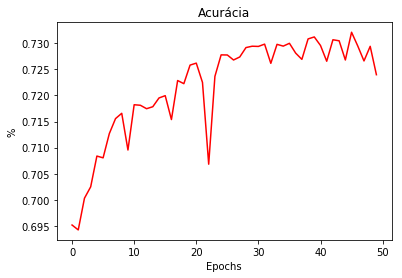

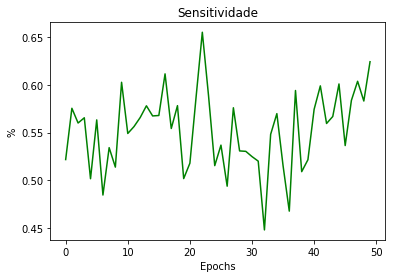

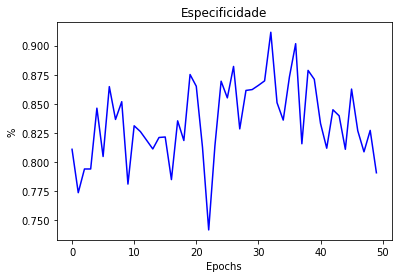

In [13]:
# Caso queiram plotar alguma coisa
import matplotlib.pyplot as plt

# Gráfico da Acurácia
plt.title('Acurácia')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.plot(accuracies, 'r-')
plt.show()

# Gráfico da Sensitividade
plt.title('Sensitividade')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.plot(recalls, 'g-')
plt.show()

# Gráfico da Especificidade
plt.title('Especificidade')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.plot(specificities, 'b-')
plt.show()


# Classificando classes individuais

Implemente aqui a modificação do processo de avaliação e treinamento para poder classificar cada classe individualmente.

- Ideia geral: treinar um perceptron por classe (exemplo positivo = exemplos da classe; exemplos negativos = exemplo de todas outras classes)
- Dado um exemplo qualquer, como decidir qual perceptron está dando a classe correta?

## Transformando o Dataset em um Vetor de 1D + Label real

In [14]:
# Dataset de treino
label_dataset_train = []
for img, label in grayscale_dataset_train:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    label_dataset_train.append((linear_img, label))

# Dataset de Teste
label_dataset_test = []
for img, label in grayscale_dataset_test:
    linear_img = img.reshape(img.shape[0]*img.shape[1],1) / 255
    label_dataset_test.append((linear_img, label))

## Função de evaluate utilizando todos os Perceptrons

In [18]:
# Função que retorna o softmax dos vetores
def softmax(ys):
    
    # Somatório de todos exponenciais
    total = 0
    for x in ys:
        total += np.exp(x)
    
    # Vetor com todos os valores em softmax
    new_ys = []
    for x in ys:
        new_ys.append(np.exp(x)/total)

# Função que retorna os valores
# True Positive, False Positive, True Negative e False Negative
def evaluate_classes(weights, classes, dataset):
    
    # Inicialização
    correct = 0
    
    # Percorre todas as imagens do dataset
    for img, label in dataset:
        
        # Adiciona o bias no fim da imagem
        img = np.append(img, 1)
        
        # Saida do perceptron
        ys = []
        for w in weights:
            ys.append(perceptron(img, w))
        
        # Descobre o label do perceptron que indicou acerto
        l = None
        for i in range(len(ys)):
            if max(ys) == ys[i]:
                l = classes[i]
                break;
        
        # Se o label for igual ao perceptron, acertou
        if label == l:
            correct += 1
          
    # Acuracia
    acuracy = correct / len(dataset)
    
    # Retorna os 3
    return acuracy

## Treinando todos os Perceptrons

In [25]:
# Array com os Pesos pra cada Perceptron
weight_classes = []
for i in classes:
    weight_classes.append((np.random.rand(1, size + 1) - 0.5)[0])

# Valor do Neta
neta = 0.01

# Valor do momento
momentum = 0.9

# Lista de todas as acuracias por época
accuracies = []

# Épocas
for epoch in range(30):
    
    # A cada época, dá shuffle no dataset
    np.random.shuffle(label_dataset_train)
    
    # Para cada exemplo no dataset de treino 
    for img, label in label_dataset_train:
      
        # Adiciona o valor do Bias no fim da imagem
        img = np.append(img, 1)
        
        # Saída de Todos os Perceptrons
        ys = []
        for w in weight_classes:
            ys.append(perceptron(img, w))
        
        # Atualizando os Pesos de cada Perceptron
        for i in range(len(weight_classes)):
            
            # Se o label da Imagem for igual o do Perceptron, fica 1
            t = 0
            if label == classes[i]:
                t = 1
            
            # Atualização dos Pesos
            loss = (t - ys[i]) * neta * img * (ys[i] * (1-ys[i]))
            weight =  weight_classes[i] + loss
            weight_classes[i] = weight
    
    # Adiciona os valores do evaluate
    accuracies.append(evaluate_classes(weight_classes, classes, label_dataset_train))
    
    # Printa a Acurácia
    print('Epoch ' + str(epoch + 1) + ':', accuracies[-1])

Epoch 1: 0.159
Epoch 2: 0.18406
Epoch 3: 0.2029
Epoch 4: 0.2101
Epoch 5: 0.2218
Epoch 6: 0.22176
Epoch 7: 0.23132
Epoch 8: 0.20822
Epoch 9: 0.24578
Epoch 10: 0.25056
Epoch 11: 0.2275
Epoch 12: 0.23288
Epoch 13: 0.22598
Epoch 14: 0.26038
Epoch 15: 0.26998
Epoch 16: 0.25294
Epoch 17: 0.26266
Epoch 18: 0.2875
Epoch 19: 0.27394
Epoch 20: 0.27508
Epoch 21: 0.26256
Epoch 22: 0.26666
Epoch 23: 0.26802
Epoch 24: 0.30582
Epoch 25: 0.31254
Epoch 26: 0.31064
Epoch 27: 0.28798
Epoch 28: 0.27868
Epoch 29: 0.30302
Epoch 30: 0.31926


# Gráfico da Acurácia de Treinamento

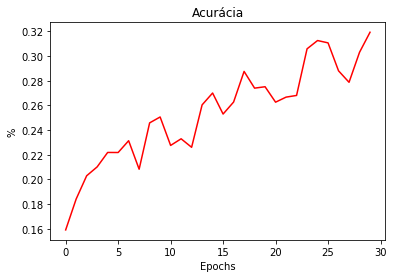

In [26]:
# Caso queiram plotar alguma coisa
import matplotlib.pyplot as plt

# Gráfico da Acurácia
plt.title('Acurácia')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.plot(accuracies, 'r-')
plt.show()


# Teste do Dataset de Teste

In [27]:
# Imprime a acurácia do dataset de Teste
print('Acurácia do Dataset de Teste:', evaluate_classes(weight_classes, classes, label_dataset_test))

Acurácia do Dataset de Teste: 0.2829
